In [1]:
!rm -rf /kaggle/working/*

In [2]:
!pip install roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 kB 2.3 MB/s eta 0:00:00


In [3]:
%env WANDB_DISABLED=True

env: WANDB_DISABLED=True


In [4]:

from roboflow import Roboflow
rf = Roboflow(api_key="6BOdc4vTuXadzG79FcwC")
project = rf.workspace("checkout-counter-detection").project("accidents-and-their-severity")
version = project.version(2)
dataset = version.download("yolov11")
                

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to accidents-and-their-severity-2 in yolov11:: 100%|██████████| 13284/13284 [00:02<00:00, 6074.90it/s] 


In [5]:
import cv2
import random
import glob as glob
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(42)

In [6]:
def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0]-bboxes[2] / 2, bboxes[1] - bboxes[3] / 2
    xmax, ymax = bboxes[0]+bboxes[2] / 2, bboxes[1] + bboxes[3] / 2
    return xmin, ymin, xmax, ymax

In [7]:
class_names = ['moderate', 'severe']
colors = np.random.uniform(0, 255, size=(len(class_names), 3))

def plot_box(image, bboxes, labels):
    # Need the image height and width to denormalize
    # the bounding box coordinates
    h, w, _ = image.shape
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        
        # denormalize the coordinates
        xmin = int(x1 * w)
        ymin = int(y1 * h)
        xmax = int(x2 * w)
        ymax = int(y2 * h)
        width = xmax - xmin
        height = ymax - ymin
        
        class_name = class_names[int(labels[box_num])]
        
        cv2.rectangle(
            image, 
            (xmin, ymin), (xmax, ymax),
            color=colors[class_names.index(class_name)],
            thickness=2
        ) 

        font_scale = min(1,max(3,int(w/500)))
        font_thickness = min(2, max(10,int(w/50)))
        
        p1, p2 = (int(xmin), int(ymin)), (int(xmax), int(ymax))
        
        # Text width and height
        tw, th = cv2.getTextSize(class_name, 0, fontScale=font_scale, thickness=font_thickness)[0]
        p2 = p1[0] + tw, p1[1] + -th - 10
        cv2.rectangle(
            image, 
            p1, p2,
            color=colors[class_names.index(class_name)],
            thickness=-1,
        )
        cv2.putText(
            image, 
            class_name,
            (xmin+1, ymin-10),
            cv2.FONT_HERSHEY_SIMPLEX,
            font_scale,
            (255, 255, 255),
            font_thickness
        )
    return image

In [8]:
# Function to plot images with the bounding boxes.
def plot(image_paths, label_paths, num_samples):
    all_training_images = glob.glob(image_paths)
    all_training_labels = glob.glob(label_paths)
    all_training_images.sort()
    all_training_labels.sort()
    
    num_images = len(all_training_images)
    
    plt.figure(figsize=(15, 12))
    for i in range(num_samples):
        j = random.randint(0,num_images-1)
        image = cv2.imread(all_training_images[j])
        with open(all_training_labels[j], 'r') as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                label = label_line[0]
                bbox_string = label_line[2:]
                x_c, y_c, w, h = bbox_string.split(' ')
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)
        result_image = plot_box(image, bboxes, labels)
        plt.subplot(2, 2, i+1)
        plt.imshow(result_image[:, :, ::-1])
        plt.axis('off')
    plt.subplots_adjust(wspace=0)
    plt.tight_layout()
    plt.show()

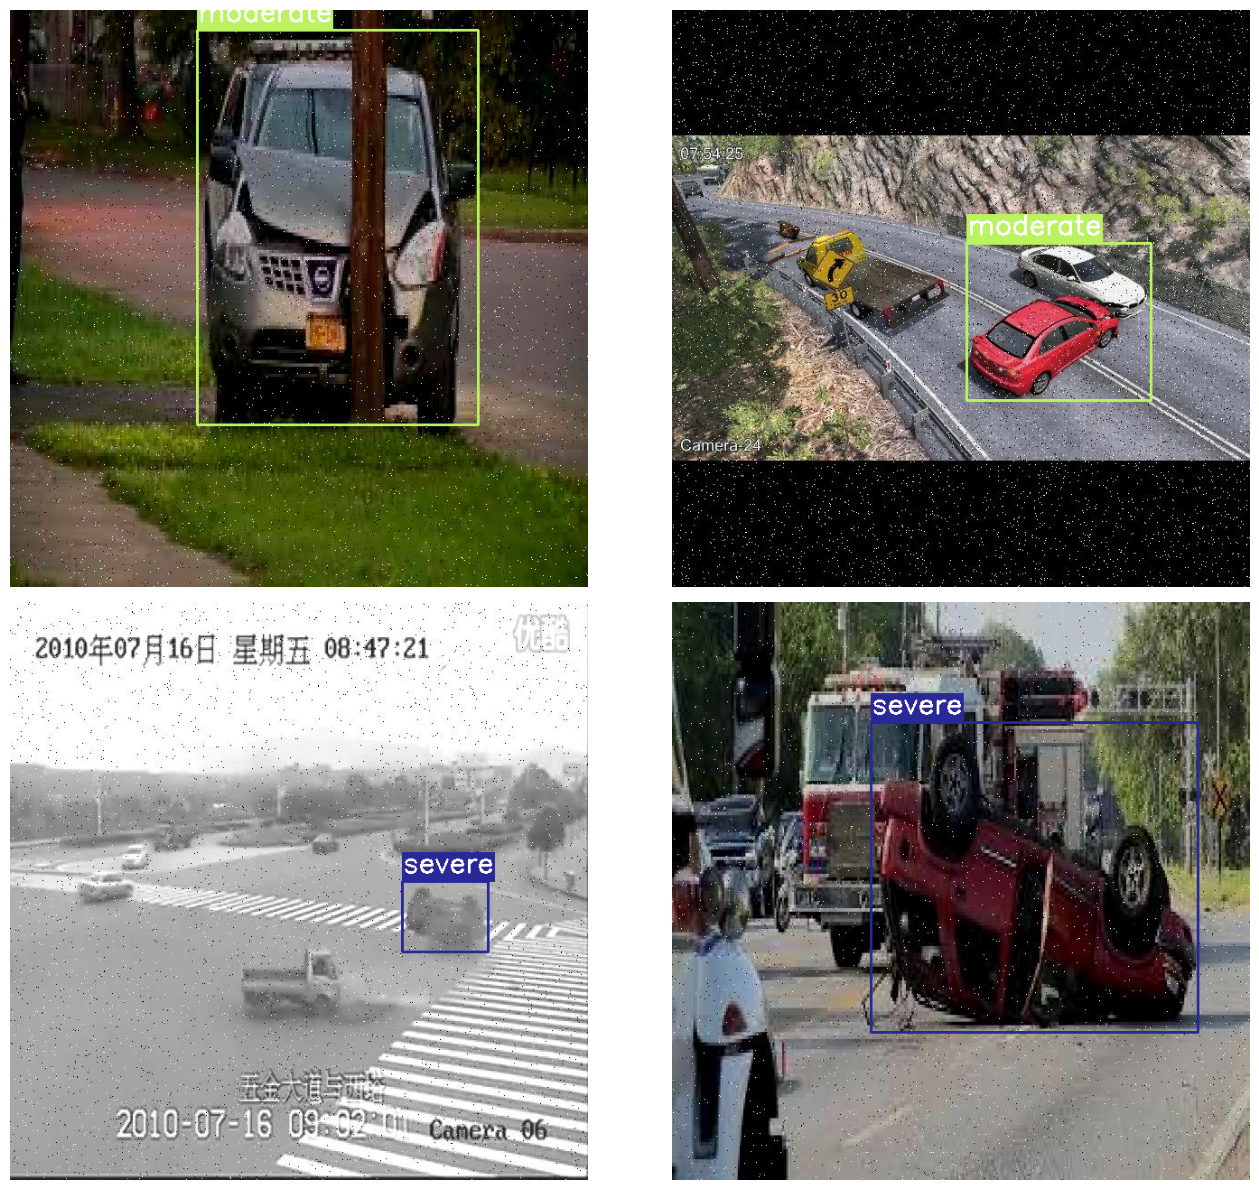

In [9]:
plot(image_paths='/kaggle/working/accidents-and-their-severity-2/train/images/*',
    label_paths='/kaggle/working/accidents-and-their-severity-2/train/labels/*',
    num_samples=4,
)

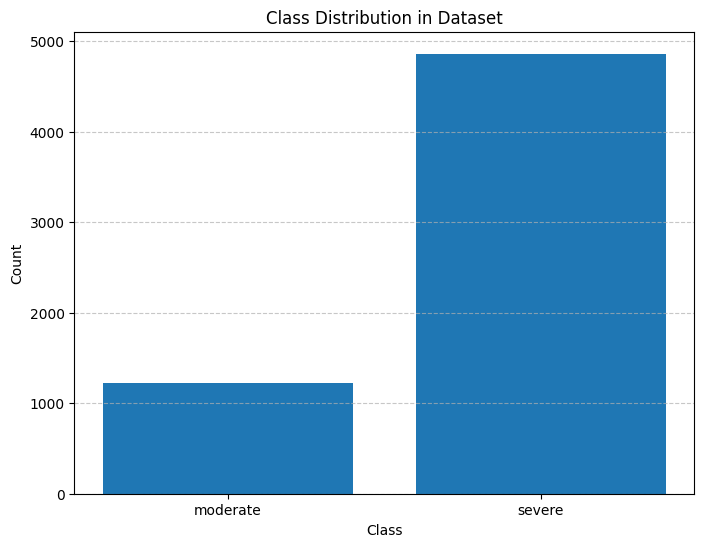

In [10]:
import os
import matplotlib.pyplot as plt



# Path to your label files directory
label_path = '/kaggle/working/accidents-and-their-severity-2/train/labels'  # Adjust this path to your labels directory

# Class names
class_names = ['moderate', 'severe']
class_indices = {name: index for index, name in enumerate(class_names)}

# Initialize a dictionary to hold counts
class_counts = {class_name: 0 for class_name in class_names}

# Count occurrences of each class in label files
for label_file in os.listdir(label_path):
    if label_file.endswith('.txt'):  # Assuming labels are in .txt format
        with open(os.path.join(label_path, label_file), 'r') as file:
            for line in file:
                class_index = int(line.split()[0])  # Get the class index from the line
                if class_index in class_indices.values():
                    class_name = class_names[class_index]
                    class_counts[class_name] += 1

# Visualization
plt.figure(figsize=(8, 6))
plt.bar(class_counts.keys(), class_counts.values())
plt.title('Class Distribution in Dataset')
plt.xlabel('Class')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


Oversampling 'moderate' class 3 times...


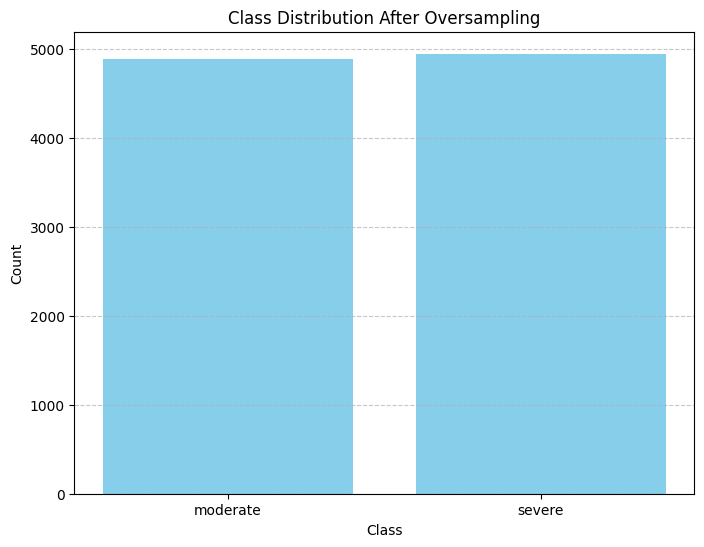

Oversampling complete!


In [11]:
import os
import shutil
import random
import matplotlib.pyplot as plt

# Path to your label and image directories
label_path = '/kaggle/working/accidents-and-their-severity-2/train/labels'  # Adjust this path
image_path = '/kaggle/working/accidents-and-their-severity-2/train/images'  # Corresponding images directory

# Class names
class_names = ['moderate', 'severe']
class_indices = {name: index for index, name in enumerate(class_names)}

# Initialize a dictionary to hold counts
class_counts = {class_name: 0 for class_name in class_names}

# Count occurrences of each class in label files
file_mapping = {class_name: [] for class_name in class_names}  # Store file paths for each class

for label_file in os.listdir(label_path):
    if label_file.endswith('.txt'):  # Assuming labels are in .txt format
        with open(os.path.join(label_path, label_file), 'r') as file:
            for line in file:
                class_index = int(line.split()[0])  # Get the class index from the line
                if class_index in class_indices.values():
                    class_name = class_names[class_index]
                    class_counts[class_name] += 1
                    file_mapping[class_name].append(label_file)

# Oversample the "moderate" class
target_class = "moderate"
oversample_factor = class_counts["severe"] // class_counts["moderate"]  # Number of duplications needed

print(f"Oversampling '{target_class}' class {oversample_factor} times...")

for label_file in file_mapping[target_class]:
    base_name = os.path.splitext(label_file)[0]
    image_file = base_name + ".jpg"  # Corresponding image file

    for i in range(oversample_factor):
        # Duplicate label file
        new_label_file = f"{base_name}_dup{i}.txt"
        shutil.copy(os.path.join(label_path, label_file), os.path.join(label_path, new_label_file))

        # Duplicate image file
        new_image_file = f"{base_name}_dup{i}.jpg"
        shutil.copy(os.path.join(image_path, image_file), os.path.join(image_path, new_image_file))

# Recalculate class distribution
class_counts_after = {class_name: 0 for class_name in class_names}

for label_file in os.listdir(label_path):
    if label_file.endswith('.txt'):
        with open(os.path.join(label_path, label_file), 'r') as file:
            for line in file:
                class_index = int(line.split()[0])
                if class_index in class_indices.values():
                    class_name = class_names[class_index]
                    class_counts_after[class_name] += 1

# Visualization of new class distribution
plt.figure(figsize=(8, 6))
plt.bar(class_counts_after.keys(), class_counts_after.values(), color='skyblue')
plt.title('Class Distribution After Oversampling')
plt.xlabel('Class')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print("Oversampling complete!")


In [12]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 898.8/898.8 kB 15.8 MB/s eta 0:00:00


In [13]:
from ultralytics import YOLO

# Load a COCO-pretrained YOLO11n model
model = YOLO("yolo11n.pt")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 5.35M/5.35M [00:00<00:00, 71.0MB/s]


In [14]:
# Use the model
results = model.train(data="/kaggle/working/accidents-and-their-severity-2/data.yaml",  
                      epochs=32, augment=True, mixup=0.1,
                     device=0)  # train the model

Ultralytics 8.3.48 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/kaggle/working/accidents-and-their-severity-2/data.yaml, epochs=32, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_c

100%|██████████| 755k/755k [00:00<00:00, 16.7MB/s]
2024-12-09 11:50:03,309	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-12-09 11:50:05,309	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /kaggle/working/accidents-and-their-severity-2/train/labels... 9417 images, 0 backgrounds, 0 corrupt: 100%|██████████| 9417/9417 [00:08<00:00, 1128.84it/s]


train: New cache created: /kaggle/working/accidents-and-their-severity-2/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


A new version of Albumentations is available: 1.4.22 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
val: Scanning /kaggle/working/accidents-and-their-severity-2/valid/labels... 557 images, 5 backgrounds, 0 corrupt: 100%|██████████| 557/557 [00:00<00:00, 1381.46it/s]


val: New cache created: /kaggle/working/accidents-and-their-severity-2/valid/labels.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train
Starting training for 32 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/32      2.41G      1.086      2.031      1.402         23        640: 100%|██████████| 589/589 [01:48<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  3.79it/s]


                   all        557        559      0.225       0.44      0.239       0.11

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/32      2.38G      1.144      1.472      1.427         19        640: 100%|██████████| 589/589 [01:45<00:00,  5.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.46it/s]

                   all        557        559      0.313      0.272      0.225      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/32      2.39G      1.127      1.368      1.416         17        640: 100%|██████████| 589/589 [01:43<00:00,  5.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.61it/s]

                   all        557        559      0.462      0.348      0.325      0.189



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/32       2.4G      1.059      1.234      1.367         13        640: 100%|██████████| 589/589 [01:42<00:00,  5.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.48it/s]

                   all        557        559       0.51      0.467      0.442      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/32      2.39G     0.9931      1.124       1.32         19        640: 100%|██████████| 589/589 [01:41<00:00,  5.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.57it/s]

                   all        557        559      0.487      0.451      0.411      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/32      2.39G     0.9448      1.038      1.285         18        640: 100%|██████████| 589/589 [01:41<00:00,  5.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.60it/s]

                   all        557        559      0.454        0.5      0.479      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/32      2.39G     0.9025      0.975      1.261         12        640: 100%|██████████| 589/589 [01:42<00:00,  5.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.60it/s]

                   all        557        559      0.504      0.593      0.513      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/32      2.38G     0.8854     0.9415      1.251         17        640: 100%|██████████| 589/589 [01:42<00:00,  5.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.55it/s]

                   all        557        559      0.483      0.531      0.489      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/32      2.39G     0.8475     0.8841      1.224         22        640: 100%|██████████| 589/589 [01:44<00:00,  5.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.53it/s]

                   all        557        559      0.449      0.461      0.418      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/32      2.39G     0.8018     0.8136      1.192         27        640: 100%|██████████| 589/589 [01:43<00:00,  5.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.63it/s]

                   all        557        559      0.552      0.456        0.5      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/32      2.39G     0.7892     0.8048      1.186         22        640: 100%|██████████| 589/589 [01:43<00:00,  5.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.55it/s]

                   all        557        559      0.555      0.494       0.51      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/32      2.38G     0.7707     0.7689      1.174         23        640: 100%|██████████| 589/589 [01:43<00:00,  5.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.34it/s]

                   all        557        559      0.561      0.506       0.53      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/32      2.38G       0.75     0.7421      1.162         22        640: 100%|██████████| 589/589 [01:42<00:00,  5.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.55it/s]

                   all        557        559      0.538      0.512      0.507      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/32      2.39G     0.7298     0.7086      1.148         15        640: 100%|██████████| 589/589 [01:42<00:00,  5.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.13it/s]

                   all        557        559      0.616      0.529      0.577      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/32      2.39G     0.7147     0.6909      1.142         23        640: 100%|██████████| 589/589 [01:42<00:00,  5.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.14it/s]

                   all        557        559      0.525        0.5      0.494      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/32      2.38G     0.6967     0.6725      1.128         22        640: 100%|██████████| 589/589 [01:42<00:00,  5.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.56it/s]

                   all        557        559      0.562        0.5      0.485      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/32      2.37G     0.6804     0.6497      1.121         18        640: 100%|██████████| 589/589 [01:43<00:00,  5.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.39it/s]

                   all        557        559      0.571      0.459      0.487      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/32      2.39G      0.664     0.6302      1.105         30        640: 100%|██████████| 589/589 [01:42<00:00,  5.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.61it/s]

                   all        557        559      0.549      0.384      0.432      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/32      2.39G      0.659     0.6169      1.105         23        640: 100%|██████████| 589/589 [01:43<00:00,  5.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.60it/s]

                   all        557        559      0.584      0.399      0.465      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/32      2.38G     0.6387     0.5942      1.091         22        640: 100%|██████████| 589/589 [01:43<00:00,  5.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.41it/s]

                   all        557        559      0.593      0.497      0.524      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/32      2.38G     0.6234      0.575      1.085         23        640: 100%|██████████| 589/589 [01:43<00:00,  5.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.51it/s]

                   all        557        559        0.5      0.527      0.514      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/32      2.39G     0.6044     0.5586      1.073         22        640: 100%|██████████| 589/589 [01:43<00:00,  5.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.68it/s]

                   all        557        559      0.474      0.537      0.504      0.347


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/32      2.46G     0.3773      0.267     0.9106          9        640: 100%|██████████| 589/589 [01:40<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.66it/s]

                   all        557        559      0.525      0.455      0.452      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/32      2.38G     0.3547     0.2459     0.8951         11        640: 100%|██████████| 589/589 [01:39<00:00,  5.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.66it/s]

                   all        557        559      0.467      0.508      0.463      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/32      2.38G     0.3355      0.235     0.8851         10        640: 100%|██████████| 589/589 [01:39<00:00,  5.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.50it/s]

                   all        557        559      0.508      0.488      0.525      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/32      2.39G     0.3116     0.2183     0.8678         10        640: 100%|██████████| 589/589 [01:39<00:00,  5.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.16it/s]

                   all        557        559      0.627      0.467      0.502      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/32      2.39G     0.2933     0.2004     0.8604         11        640: 100%|██████████| 589/589 [01:40<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.74it/s]

                   all        557        559      0.615      0.455      0.498      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/32      2.38G     0.2773     0.1933     0.8512          9        640: 100%|██████████| 589/589 [01:39<00:00,  5.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.65it/s]

                   all        557        559       0.53      0.521       0.49      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/32      2.38G     0.2651     0.1835     0.8448          9        640: 100%|██████████| 589/589 [01:40<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.79it/s]

                   all        557        559      0.604      0.519      0.532      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/32      2.39G     0.2539      0.176     0.8422          9        640: 100%|██████████| 589/589 [01:39<00:00,  5.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.67it/s]

                   all        557        559       0.55      0.503        0.5      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/32      2.39G     0.2411      0.169     0.8367          9        640: 100%|██████████| 589/589 [01:39<00:00,  5.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.02it/s]

                   all        557        559      0.593      0.485      0.517      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/32      2.38G     0.2311     0.1622     0.8301         12        640: 100%|██████████| 589/589 [01:39<00:00,  5.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.88it/s]

                   all        557        559      0.576      0.483      0.502      0.364



32 epochs completed in 0.946 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 5.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.48 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 238 layers, 2,582,542 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:06<00:00,  2.83it/s]


                   all        557        559      0.589      0.542      0.565      0.382
              moderate        183        183      0.506      0.437      0.447      0.303
                severe        369        376      0.672      0.648      0.684       0.46
Speed: 0.2ms preprocess, 7.5ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs/detect/train


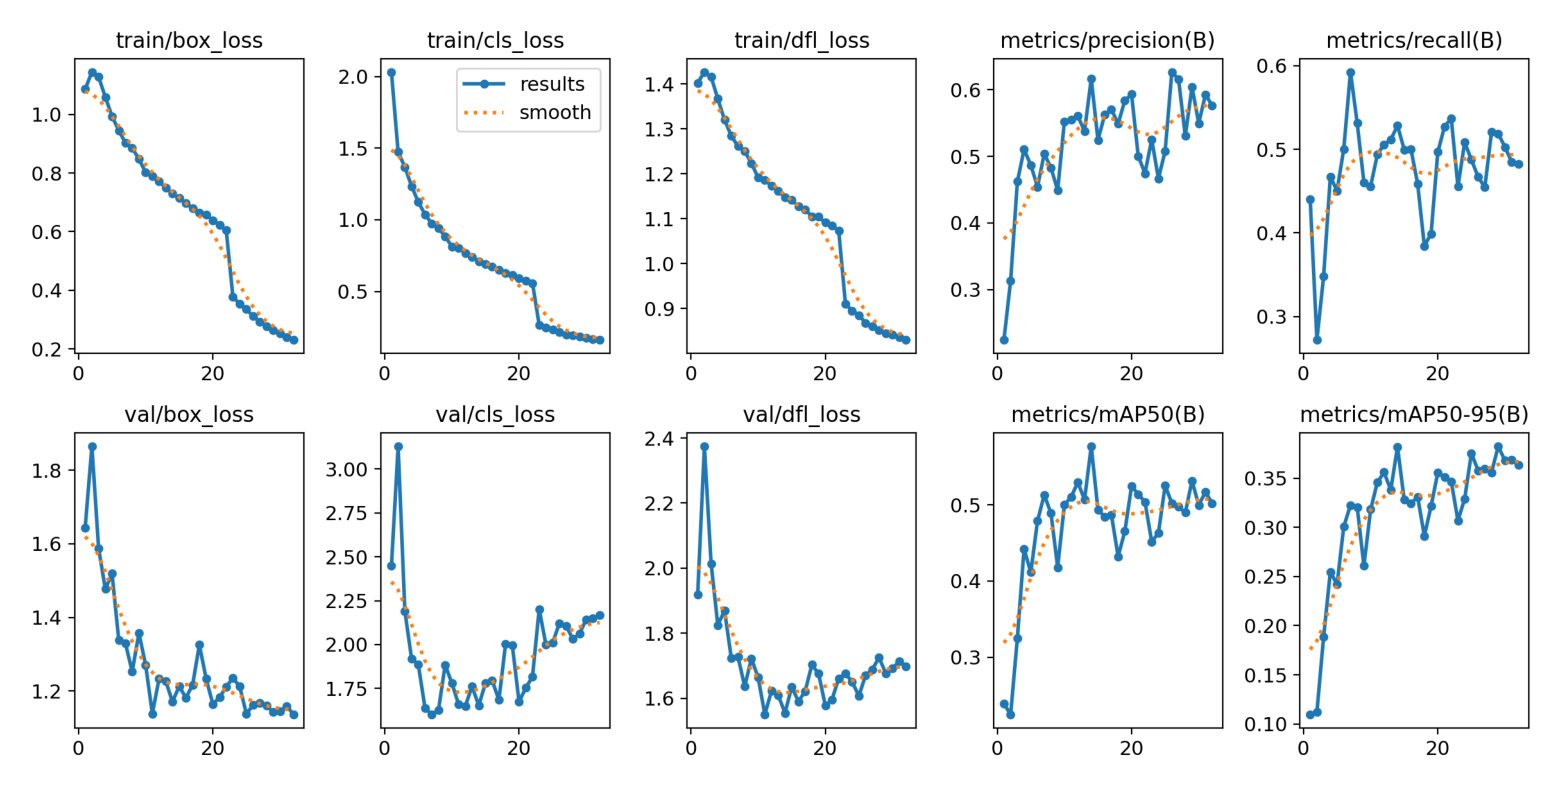

In [15]:

img_path = '/kaggle/working/runs/detect/train/results.png'
img = plt.imread(img_path)

plt.figure(figsize=(20, 10))
plt.imshow(img)
plt.axis(False)
plt.show()

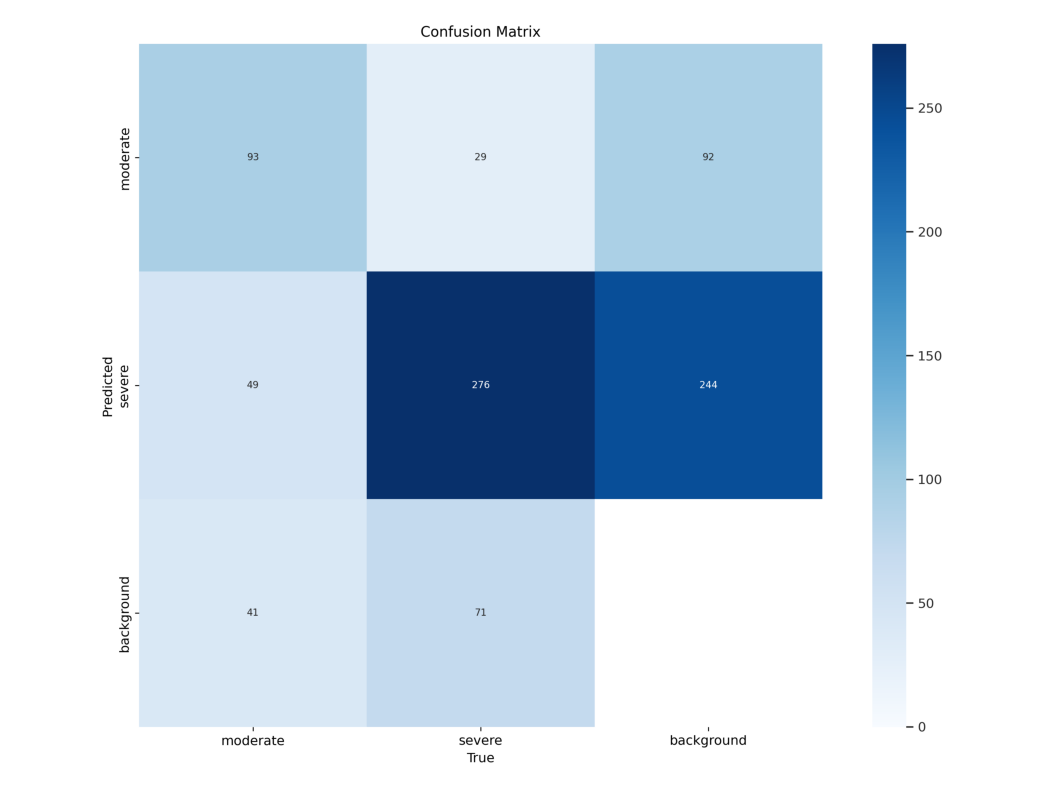

In [16]:
img_path = '/kaggle/working/runs/detect/train/confusion_matrix.png'
img = plt.imread(img_path)

plt.figure(figsize=(20, 10))
plt.imshow(img)
plt.axis(False)
plt.show()

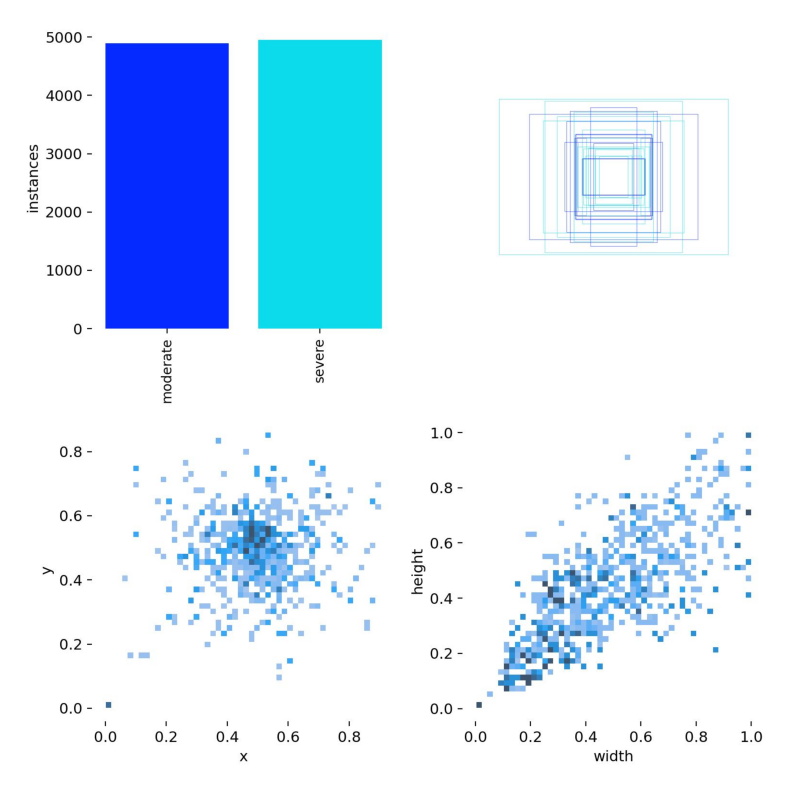

In [17]:
img_path = '/kaggle/working/runs/detect/train/labels.jpg'
img = plt.imread(img_path)

plt.figure(figsize=(20, 10))
plt.imshow(img)
plt.axis(False)
plt.show()